# **Attributes Testing with CUDA**

In this notebook, we are comparing all attributes implemented by [d2geo](https://github.com/jcfaracco/d2geo) after moving them to CUDA. The proposal is to verify the speedup achieved by each attributes compared to the original one implemented using GPU.

This architecture is using a single node only. Despite of being using a Dask array, there is no distributed dask workers associated to each computation.

In [1]:
!pip3 install segyio fsspec scikit-image > /dev/null 2>&1
# Installing cupy for CUDA
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  14495      0 --:--:-- --:--:-- --:--:-- 14495
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9MB 48kB/s 
     |████████████████████████████████| 1.0MB 38.4MB/s 
+ set +ex
Installation succeeded!


Installing RAPIDS AI

In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 277 (delta 59), reused 40 (delta 20), pack-reused 171
Receiving objects: 100% (277/277), 80.66 KiB | 16.13 MiB/s, done.
Resolving deltas: 100% (121/121), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bio

In [1]:
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
!python3 rapidsai-csp-utils/colab/install_rapids.py nightly
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Installing RAPIDS Nightly 21.08
Starting the RAPIDS+BlazingSQL install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - gcsfs
    - llvmlite
    - openssl
    - python=3.7
    - rapids-blazing=21.08


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20210324.1      |       h9c3ff4c_0        1015 KB  conda-forge
    aiohttp-3.7.4.post0        |   py37h5e8e339_0         625 KB  conda-forge
    anyio-3.2.1                |   py37h89c1867_0         138 KB  conda-forge
    appdirs-1.4.4              |     pyh9f0ad1d_0     

###**Getting the Dataset**

Seismic datasets are usually computationally represented as 3D scalar fields, being each voxel of the volume a 32-bits floating-point (amplitude). The Society of Exploration Geophysics (SEG) made available an [online repository](https://wiki.seg.org/wiki/Open_data) with major surveys from onshore and offshore areas.

For this tutorial, we will use two marine seismic blocks from the Netherlands and New Zealand offshore regions (as the original paper does).

The dataset is the F3-Netherlands (https://wiki.seg.org/wiki/F3_Netherlands): a 1.2 GByte time migrated 3D seismic cube. It is available through the Creative Commons 3.0 license. Check the [dGB repository](https://terranubis.com/datainfo/F3-Demo-2020) for a complete reference.

The dataset was modified to adjust the header such that it could be read by the [segyio](https://github.com/equinor/segyio) library:


In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D" -O F3.sgy && rm -rf /tmp/cookies.txt

--2021-07-05 16:39:37--  https://docs.google.com/uc?export=download&confirm=pB9J&id=1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D
Resolving docs.google.com (docs.google.com)... 142.250.65.78, 2607:f8b0:4004:815::200e
Connecting to docs.google.com (docs.google.com)|142.250.65.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-b8-docs.googleusercontent.com/docs/securesc/pg6dec9otf5hu4a9s1dnuaklrlto9bej/ukmhh320ctq3npo2luc2dp3rfqglucn0/1625503125000/17311170770924402329/09050830912033590541Z/1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D?e=download [following]
--2021-07-05 16:39:37--  https://doc-00-b8-docs.googleusercontent.com/docs/securesc/pg6dec9otf5hu4a9s1dnuaklrlto9bej/ukmhh320ctq3npo2luc2dp3rfqglucn0/1625503125000/17311170770924402329/09050830912033590541Z/1ZPsRasiCs1NfN72_Skn9YUgfipZ5KD4D?e=download
Resolving doc-00-b8-docs.googleusercontent.com (doc-00-b8-docs.googleusercontent.com)... 142.250.73.193, 2607:f8b0:4004:829::2001
Connecting to doc-00-

In [4]:
# Workaround to fix issues with newest matplotlib
!pip3 install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 93 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2


###**Data Preparation**

Importing Python dependencies.


In [5]:
# Basic imports.
import os
import segyio
import sys
import time
import numpy as np
import cupy as cp

# Dataframe libraries for attribute computation.
import dask.array as da
import dask.dataframe as ddf

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable

%matplotlib inline

###**Reading Seismic Cubes**

Firstly, we will explore the impact of RAPIDS for seismic facies classification on the F3 seismic block.

Let's define the input file directory:

In [6]:
input_file = 'F3.sgy'

Pre- and post-stack seismic cubes are often stored following the [SEG-Y standard](https://en.wikipedia.org/wiki/SEG-Y). Notice that most of the files available in SEG Open data repository are released as .sgy files.

Equinor made available an easy-to-use SEG-Y file reader with a Python interface. The segyio is a small LGPL licensed C library for easy interaction with SEG-Y and Seismic Unix formatted seismic data, with language bindings for both Python and Matlab.

Let's make a preliminary check on the seismic cubes using the **segyio** library and verify that number of inlines, crosslines, and time slices match the reference we have on SEG repository:

In [7]:
def inspect_seismic_cubes(file_name):
    segy_file = segyio.open(file_name)
    iline_start = int(segy_file.ilines[0])
    iline_end = int(segy_file.ilines[-1])
    iline_offset = int(segy_file.ilines[1] - segy_file.ilines[0])

    xline_start = int(segy_file.xlines[0])
    xline_end = int(segy_file.xlines[-1])
    xline_offset = int(segy_file.xlines[1] - segy_file.xlines[0])

    time_start = int(segy_file.samples[0])
    time_end = int(segy_file.samples[-1])
    time_offset = int(segy_file.samples[1] - segy_file.samples[0])
        
    print("File: {} \n"
          "Inline range: [{}, {}]. Offset: {}\n"
          "Crossline range: [{}, {}]. Offset: {}\n"
          "Time range: [{}, {}]. Offset: {}".format(os.path.basename(file_name),
                                                       iline_start, iline_end, iline_offset, 
                                                       xline_start, xline_end, xline_offset, 
                                                       time_start, time_end, time_offset))
    metadata = {
        'inline': (iline_start, iline_end, iline_offset),
        'crossline': (xline_start, xline_end, xline_offset),
        'time': (time_start, time_end, time_offset)
    }
    
    return metadata

metadata = inspect_seismic_cubes(input_file)

File: F3.sgy 
Inline range: [100, 750]. Offset: 1
Crossline range: [300, 1250]. Offset: 1
Time range: [4, 1848]. Offset: 4


Read the seismic cube as NumPy array. Notice that this may take a while depending on the size of the input volume.

In [8]:
original_cube = np.array(segyio.tools.cube(input_file))
original_cube = np.ascontiguousarray(original_cube, 'float32')

print("Original cube dimension:", original_cube.shape)

Original cube dimension: (651, 951, 462)


In [9]:
# We perform slicing to get a central region on the dataset
# to increase training quality and ensure it will fit GPU memory.
def get_sub_cube(cube, examples_percent):
    assert examples_percent > 0 and examples_percent <= 1.0, "Percent must be in (0,1] range."

    i_num, x_num, t_num = cube.shape

    i_start_idx = int((i_num - (i_num * examples_percent))/2)
    i_end_idx   = int(i_start_idx + (examples_percent * i_num))

    x_start_idx = int((x_num - (x_num * examples_percent))/2)
    x_end_idx   = int(x_start_idx + (examples_percent * x_num))

    t_start_idx = int((t_num - (t_num * examples_percent))/2)
    t_end_idx   = int(t_start_idx + (examples_percent * t_num))

    return cube[i_start_idx:i_end_idx,
                x_start_idx:x_end_idx,
                t_start_idx:t_end_idx]

# Change the following variable if you want to work with bigger or smaller cube fractions.
# The interval for @examples_percent is (0,1]. Defining examples_percent = 0.9
# will pick a central crop on the cube corresponding to 90% of available samples.
examples_percent = 0.9
cube = get_sub_cube(original_cube, examples_percent)

cube_gpu = cp.array(cube)

print("Sub-cube dimension:", cube.shape)

Sub-cube dimension: (585, 855, 415)


###**Visualizing Seismic Section**

For sanity check, let's plot the inline at position 50 (`inline_index=50`). Therefore, we define an auxiliary plot_slice procedure, that will also be used thereafter.

Notice that axes are swapped for visualization purposes. Seismic sections are usually visualized using Z axes as depth/time dimension, and X or Y axes being inline or crossline.


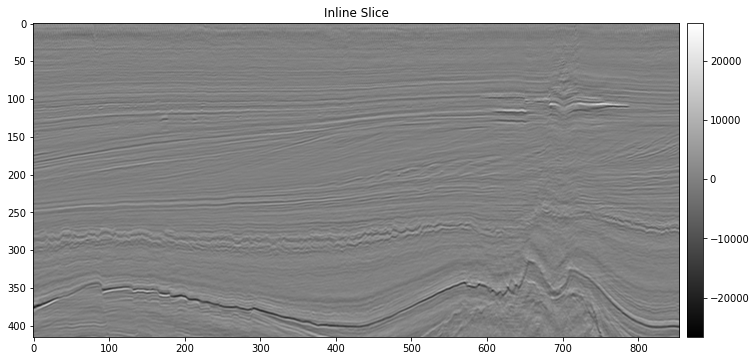

In [10]:
def plot_slice(slice, title=None, cmap='gray', img_scale=0.015, interpolation='bicubic', is_discrete=False):
    img_h = int(slice.shape[0] * img_scale)
    img_w = int(slice.shape[1] * img_scale)    

    plt.figure(figsize=(img_w, img_h))
    if title: plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.1)
    
    if is_discrete:
        cmap = plt.get_cmap(cmap, np.max(slice)-np.min(slice)+1)
        im = ax.imshow(slice, cmap=cmap, interpolation=None, vmin = np.min(slice)-.5, vmax = np.max(slice)+.5)
        plt.colorbar(im, cax=cax, ticks=np.arange(np.min(slice),np.max(slice)+1))
    else:        
        im = ax.imshow(slice, cmap=cmap, interpolation=interpolation)
        plt.colorbar(im, cax=cax);
        
inline_index = 50
plot_slice(np.swapaxes(cube[inline_index,:,:], 0, 1), title='Inline Slice')

###**Attribute Computation**

To compute seismic attributes we will use [d2geo](https://github.com/jcfaracco/d2geo). This library has Python implementations in CPU and (few) GPU for the most common attributes used for processing and interpretation.

We are using a branch of the original repo with adjustments to run the latest Dask versions. To clone it:


In [11]:
!rm -rf d2geo/
!git clone https://github.com/jcfaracco/d2geo.git -b new

Cloning into 'd2geo'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 276 (delta 145), reused 125 (delta 65), pack-reused 52
Receiving objects: 100% (276/276), 84.71 KiB | 12.10 MiB/s, done.
Resolving deltas: 100% (171/171), done.


The attributes will be computed and stored in a Dask dataframe, which is a large parallel dataframe composed of many smaller Pandas DataFrames.

Notice that most d2geo attributes perform computations on CPU. Total time to process may vary depending upon your environment. This current attribute we are calculating was already ported to GPU.

Right now, we are measuring three types of attributes: Complex, Signal and Frequency.

The number of iteratitions are 50 to calculate the mean and the standard deviation.

In [12]:
sys.path.append('./d2geo/attributes')

from statistics import mean, stdev

from d2geo.attributes.ComplexTrace import ComplexAttributes
from d2geo.attributes.SignalProcess import SignalProcess
from d2geo.attributes.Frequency import Frequency

complex_att_cpu = ComplexAttributes()
signal_process_cpu = SignalProcess()
frequency_cpu = Frequency()

complex_att_gpu = ComplexAttributes(use_cuda=True)
signal_process_gpu = SignalProcess(use_cuda=True)
frequency_gpu = Frequency(use_cuda=True)

funcs_complex = [
    'hilbert_transform',
    'envelope',
    'instantaneous_phase',
    'cosine_instantaneous_phase',
    'relative_amplitude_change',
    'instantaneous_frequency',
    'instantaneous_bandwidth',
    'dominant_frequency',
    'frequency_change',
    'sweetness',
    'quality_factor',
    'response_phase',
    'response_frequency',
    'response_amplitude',
    'apparent_polarity',
]

funcs_signal = [
    'first_derivative',
    'second_derivative',
    'histogram_equalization',
    'time_gain',
    'rescale_amplitude_range',
    'rms',
    'trace_agc',
    'gradient_magnitude',
    'reflection_intensity',
    'phase_rotation',
]

funcs_frequency = [
    'lowpass_filter',
    'highpass_filter',
    'bandpass_filter',
    'cwt_ricker',
    'cwt_ormsby',
]

max_speed_up_x = 0
max_speed_up_y = 0

ntimes = 50

speedups = list()
for func in funcs_complex:
    array = list()
    for i in range(ntimes):
        cpu_func = getattr(complex_att_cpu, func)
        gpu_func = getattr(complex_att_gpu, func)

        start_cpu = time.time()
        cpu_func(cube)
        end_cpu = time.time()

        start_gpu = time.time()
        gpu_func(cube_gpu)
        end_gpu = time.time()

        rate = (end_cpu - start_cpu)/(end_gpu - start_gpu)

        if rate > max_speed_up_x:
            max_speed_up_x = rate

        if rate > max_speed_up_y:
            max_speed_up_y = rate

        array.append(rate)

    speedups.append({'func': func, 'marker': 'o', 'data': [mean(array), mean(array), stdev(array)]})

for func in funcs_signal:
    array = list()
    for i in range(ntimes):
        cpu_func = getattr(signal_process_cpu, func)
        gpu_func = getattr(signal_process_gpu, func)

        start_cpu = time.time()
        if func == 'rescale_amplitude_range':
            cpu_func(cube, 0, 255)
        elif func == 'phase_rotation':
            cpu_func(cube, 0)
        else:
            cpu_func(cube)
        end_cpu = time.time()

        start_gpu = time.time()
        if func == 'rescale_amplitude_range':
            gpu_func(cube_gpu, 0, 255)
        elif func == 'phase_rotation':
            gpu_func(cube_gpu, 0)
        else:
            gpu_func(cube_gpu)
        end_gpu = time.time()

        rate = (end_cpu - start_cpu)/(end_gpu - start_gpu)

        if rate > max_speed_up_x:
            max_speed_up_x = rate

        if rate > max_speed_up_y:
            max_speed_up_y = rate
    
        array.append(rate)

    speedups.append({'func': func, 'marker': 's', 'data': [mean(array), mean(array), stdev(array)]})

for func in funcs_frequency:
    array = list()
    for i in range(ntimes):
        cpu_func = getattr(frequency_cpu, func)
        gpu_func = getattr(frequency_gpu, func)

        start_cpu = time.time()
        if func == 'bandpass_filter':
            cpu_func(cube, 5, 20)
        elif func == 'cwt_ormsby':
            cpu_func(cube, np.array([5, 10, 20, 40]))
        else:
            cpu_func(cube, 5)
        end_cpu = time.time()

        start_gpu = time.time()
        if func == 'bandpass_filter':
            gpu_func(cube_gpu, cp.int(5), cp.int(20))
        elif func == 'cwt_ormsby':
            gpu_func(cube_gpu, cp.array([5, 10, 20, 40]))
        else:
            gpu_func(cube_gpu, cp.int(5))
        end_gpu = time.time()

        rate = (end_cpu - start_cpu)/(end_gpu - start_gpu)

        if rate > max_speed_up_x:
            max_speed_up_x = rate

        if rate > max_speed_up_y:
            max_speed_up_y = rate

        array.append(rate)

    speedups.append({'func': func, 'marker': '^', 'data': [mean(array), mean(array), stdev(array)]})

###**Visualizing the Speedups**

In next section, we plot the speedup line. Values close to (0, 0) means low speeups comparing CPU to GPU. Points further to the (0, 0) center, mean nice results after moving to GPU.

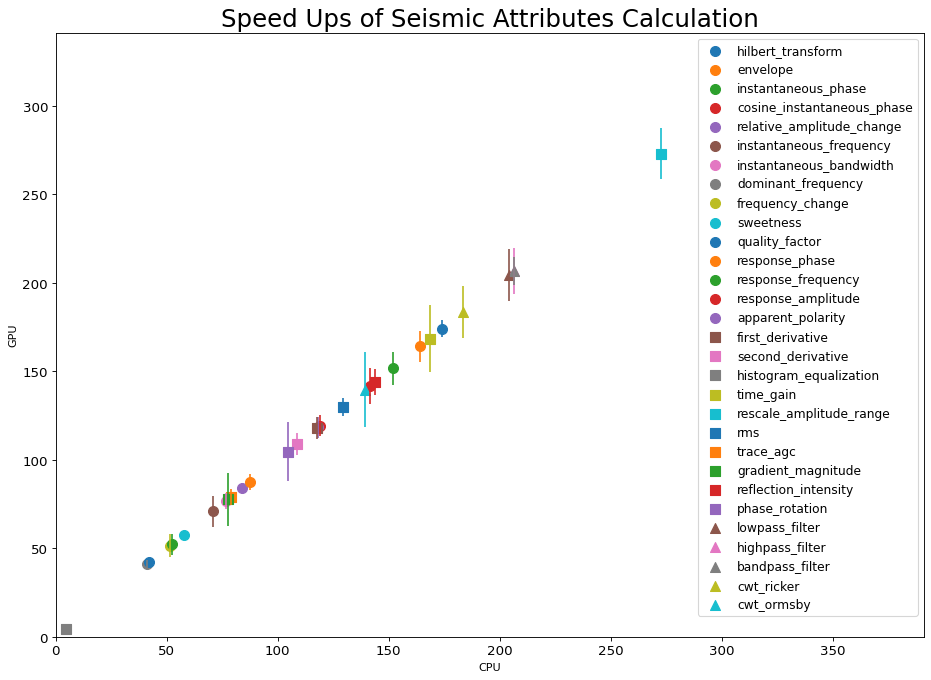

In [13]:
categories = funcs_complex + funcs_signal + funcs_frequency
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, func_dict in enumerate(speedups):
    plt.scatter(x=[func_dict['data'][0]], y=[func_dict['data'][1]],
                s=80, marker=func_dict['marker'], label=str(func_dict['func']))
    plt.errorbar(x=[func_dict['data'][0]], y=[func_dict['data'][1]],
                 yerr=[func_dict['data'][2]], linestyle="None")

# Decorations
plt.gca().set(xlim=(0, max_speed_up_x + 100), ylim=(0, max_speed_up_y + 50),
              xlabel='CPU', ylabel='GPU')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Speed Ups of Seismic Attributes Calculation", fontsize=22)
plt.legend(fontsize=11)    
plt.show() 